In [412]:
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy 
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sys import getsizeof

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

from sklearn.model_selection import train_test_split
from rfpimp import *

from functools import reduce

scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True,average='micro')

In [413]:
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')

print(Counter(train_target.damage_grade))

y = train_target.damage_grade

Counter({2: 148259, 3: 87218, 1: 25124})


In [414]:
X = create_X(df)


In [415]:
id_cols = [i for i in X.columns if 'id' in i]

In [417]:
notidcols = [i for i in X.columns if i not in id_cols]

In [419]:
X = X[notidcols]

In [420]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [427]:
all_clfs = [('Naive Bayes',MultinomialNB()), ('Logistic Regression', LogisticRegression()), 
       ('Random Forest', RandomForestClassifier())]

In [429]:
std_ = []
mean_ = []
names = []
for i in all_clfs:
    single = i[1]
    v = cross_val_score(estimator=single,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)
    std_.append(v.std())
    mean_.append(v.mean())
    names.append(i[0])

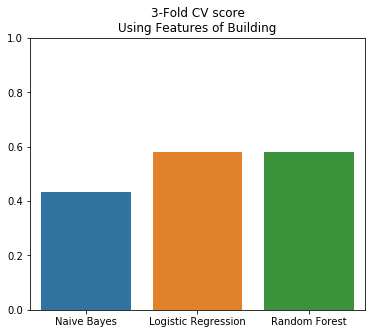

In [438]:
plt.figure(figsize=(6,5))
plt.title('3-Fold CV score\nUsing Features of Building')
plt.ylim([0,1])
g = sns.barplot(x=names, y=mean_, ci=std_)


In [447]:
X = create_X(df)


In [448]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
fe = FreqEncode()
fe.fit(X,geo_features)
X = fe.transform(X)

In [449]:
std_ = []
mean_ = []
names = []
for i in all_clfs:
    single = i[1]
    v = cross_val_score(estimator=single,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)
    std_.append(v.std())
    mean_.append(v.mean())
    names.append(i[0])

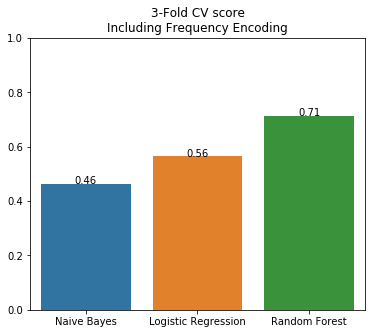

In [458]:
plt.figure(figsize=(6,5))
plt.title('3-Fold CV score\nIncluding Frequency Encoding')
plt.ylim([0,1])
g = sns.barplot(x=names, y=mean_, ci=std_)

for i,j in enumerate(mean_):
    g.text(i, j, round(j,2), color='black', ha="center")

In [459]:
tar_enc = TarEncode(func=np.mean)
tar_enc.fit(X, y.values, geo_features)
X = tar_enc.transform(X)

In [460]:
std_ = []
mean_ = []
names = []
for i in all_clfs:
    single = i[1]
    v = cross_val_score(estimator=single,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)
    std_.append(v.std())
    mean_.append(v.mean())
    names.append(i[0])

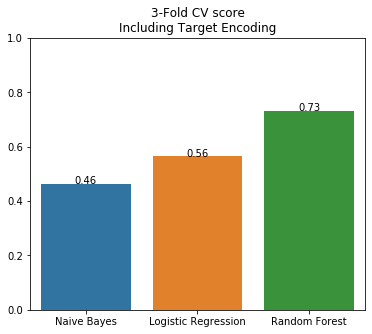

In [461]:
plt.figure(figsize=(6,5))
plt.title('3-Fold CV score\nIncluding Target Encoding')
plt.ylim([0,1])
g = sns.barplot(x=names, y=mean_, ci=std_)

for i,j in enumerate(mean_):
    g.text(i, j, round(j,2), color='black', ha="center")

In [475]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, n_jobs=-1)

ordinal_rf = OrdinalClassifier(model)

In [462]:
feat_encode = FeatEncode(func=np.mean, name='_isurban')
feat_encode.fit(X,X.height_percentage.values, cols = geo_features)
X = feat_encode.transform(X)

In [463]:
std_ = []
mean_ = []
names = []
for i in all_clfs:
    single = i[1]
    v = cross_val_score(estimator=single,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)
    std_.append(v.std())
    mean_.append(v.mean())
    names.append(i[0])

In [231]:
def create_X(df):
    X = df.copy()
    
#     X['disc'] = X['ground_floor_type'].astype(str) + X['other_floor_type'].astype(str)  # new feature
    
    cat_cols = X.columns[X.dtypes == 'object']
    num_cols = [i for i in X.columns if i not in cat_cols]
    
    x1 = X[cat_cols].apply(LabelEncoder().fit_transform)
    X = pd.concat([X[num_cols], x1], axis=1)
    
    return X

def _new_ids(l1, l2):
    '''l1 and l2 are np.arrays
    l1 = train array
    l2 = test array
    '''
    
    if not isinstance(l1, np.ndarray):
        l1 = np.array(l1)
    if not isinstance(l2, np.ndarray):
        l2 = np.array(l2)
    
    mode = scipy.stats.mode(l1)[0][0]  # mode value of train
    
    bool_arr = np.array([i in l1 for i in l2])
    out = l2.copy()
    out[~bool_arr] = mode
    
    
    return out

def replace_new_ids(train_df, test_df, cols):
    '''
    train_df = train_df
    test_df = test_df
    cols = list of columns which have new ids not in train_df
    
    This function will replace any new values in the cols of 
    test_df with the mode of trains_df
    '''
    for column in cols:
        test_df.loc[:,column] = _new_ids(train_df.loc[:,column], test_df.loc[:,column])
    return train_df, test_df
    
    
def geo23_in_geo1(X_train, X_test):
    ''' Requirement: No new geo_level_2 ids in X_test'''
    
    dic_1_2 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_2_id'].nunique())
    dic_1_3 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_3_id'].nunique())
    
    for frame in [X_train, X_test]:
        frame['count12'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_2[x])
        frame['count13'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_3[x])
    
    return X_train, X_test
    



def new_rows(l1, l2):
    s = set(l2) - set(l1)
    return len([i for i in l2 if i in s])

class FreqEncode:
    def __init__(self):
        self.freq_dict = {}
    
    def create_dict(self,train_col):
        return dict(train_col.value_counts())
    
    def fit(self, X_train, cols):
        '''
        X_train = train_df
        cols for which we need to encode frequency
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i])
            self.freq_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_fq'] = X_test[i].apply(lambda x: self.freq_dict[i][x])
        return X_test
    

class TarEncode:
    def __init__(self, func):
        self.tar_dict = {}
        self.func = func
        
    def create_dict(self, train_col, y):
        col1 = train_col.values
        df = pd.DataFrame(zip(col1, y), columns=['c1','c2'])
        df = df.groupby('c1',as_index=False).agg({'c2':self.func})
        df.columns = ['c1','c2']
        
        d = dict((i,j) for i,j in zip(df['c1'], df['c2']))
        return d
    
    def fit(self, X_train, y, cols):
        '''
        X_train = pandas dataframe 
        y = target variables np.array
        cols = list of columns for which we need to target encode
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i], y)
            self.tar_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_tq'] = X_test[i].apply(lambda x: self.tar_dict[i][x])
        return X_test
    

class FeatEncode:
    def __init__(self, func, name='_featenc'):
        '''
        Encoding the categorical feature with continuous feature mean
        both are passed in fit function
        '''
        self.tar_dict = {}
        self.func = func
        self.name = name
        
    def create_dict(self, train_col, y):
        col1 = train_col.values
        df = pd.DataFrame(zip(col1, y), columns=['c1','c2'])
        df = df.groupby('c1',as_index=False).agg({'c2':self.func})
        df.columns = ['c1','c2']
        
        d = dict((i,j) for i,j in zip(df['c1'], df['c2']))
        return d
    
    def fit(self, X_train, y, cols):
        '''
        X_train = pandas dataframe 
        y = target variables np.array
        cols = list of columns for which we need to target encode
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i], y)
            self.tar_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+ self.name] = X_test[i].apply(lambda x: self.tar_dict[i][x])
        return X_test
    

class TarEncodeMoreInfo:
    def __init__(self):
        self.df_dict = {}
    
    def fit(self, X_train, y, cols):
        '''
        X_train = pandas dataframe 
        y = target variables np.array
        cols = list of columns for which we need to target encode
        '''
        self.cols = cols
        df = X_train[cols]
        uniq_y = np.unique(y)
        tars = []
        for i in uniq_y:
            name = 'tar_' + str(i)
            tars.append(name)
            df[name] = (y==i).astype(int)
        
        for col in self.cols:
            sel = [col]+tars
            sel = df[sel]
            sel.columns = [col]+[f"{col}_{t}" for t in tars]
            vals = sel.columns[1:]
            self.df_dict[col] = sel.groupby(col, as_index=False)[vals].mean()
        
        
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            right = self.df_dict[i]
            X_test = pd.merge(X_test, right, left_on=i, right_on=i, how='left')
            
        return X_test
    

In [134]:
X = create_X(df)
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

fe = FreqEncode()
fe.fit(X,geo_features)
X = fe.transform(X)


tar_enc = TarEncode(func=np.mean)
tar_enc.fit(X, y.values, geo_features)
X = tar_enc.transform(X)


In [52]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=5, n_jobs=-1)

In [477]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

> Removing geo_ids and build_id is good

In [478]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=999)

In [348]:
from xgboost import XGBClassifier

In [479]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, n_jobs=-1)

ordinal_rf = OrdinalClassifier(model)

In [480]:
ordinal_rf.fit(X_train, y_train-1)

In [481]:
true_test.shape

(86868, 45)

In [482]:
preds = ordinal_rf.predict(X_test)

In [483]:
f1_score(y_test-1, preds, average='micro')

0.7561366992639449

In [493]:
score_df = pd.DataFrame([['RandomForest',0.73],['OrdinalRF',0.756]], columns = {'model', 'score'})

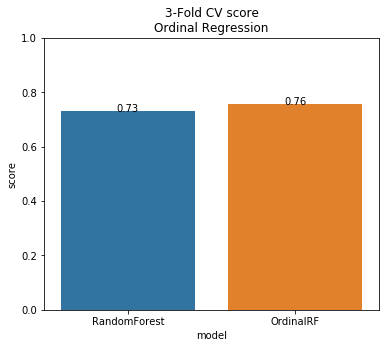

In [498]:
plt.figure(figsize=(6,5))
plt.title('3-Fold CV score\nOrdinal Regression')
plt.ylim([0,1])
g = sns.barplot(x=score_df.model,y = score_df.score)
for i,j in enumerate(score_df.score):
    g.text(i, j, round(j,2), color='black', ha="center")

In [364]:
ordinal_rf.fit(X,y-1)

In [365]:
train_preds = ordinal_rf.predict(X)

In [367]:
f1_score(y-1, train_preds, average='micro')

0.8292715684130145

In [368]:
true_test = pd.read_csv('../input/test_values.csv')

true_test = create_X(true_test)
# true_test['geo_comb'] = true_test[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']].astype(str).apply(combine_cols, axis=1)

_, true_test = replace_new_ids(X, true_test, geo_features)

true_test = fe.transform(true_test)
true_test = tar_enc.transform(true_test)

In [369]:
X.shape, true_test.shape

((260601, 45), (86868, 45))

In [383]:
probs = ordinal_rf.predict_proba(true_test)

In [384]:
probs

(86868, 3)

In [388]:
from sklearn.calibration import CalibratedClassifierCV

In [389]:
rf = RandomForestClassifier(n_estimators=30, min_samples_leaf=5, n_jobs=-1)

In [390]:
crf = CalibratedClassifierCV(base_estimator=rf,cv=3)

In [407]:
X['f1'] = X['geo_level_2_id_fq'] - X['geo_level_1_id_fq']
X['f2'] = X['geo_level_3_id_fq'] - X['geo_level_2_id_fq']


In [410]:
X['f3'] = X['geo_level_2_id_tq'] - X['geo_level_1_id_tq']
X['f4'] = X['geo_level_3_id_tq'] - X['geo_level_2_id_tq']


In [408]:
rf = RandomForestClassifier(n_estimators=30, min_samples_leaf=5, n_jobs=-1)

In [409]:
cross_val_score(estimator=rf,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75379887, 0.75537597, 0.75377885])

In [411]:
cross_val_score(estimator=rf,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75247502, 0.75292398, 0.75392851])

In [392]:
crf.calibrated_classifiers_

In [394]:
t = crf.predict(X)

In [403]:
pd.Series(t).value_counts(normalize=True)

2    0.637638
3    0.287060
1    0.075303
dtype: float64

In [404]:
pd.Series(y).value_counts(normalize=True)

2    0.568912
3    0.334680
1    0.096408
Name: damage_grade, dtype: float64

In [402]:
f1_score(y, t, average='micro')

0.8062939129166811

In [137]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.7572687853196506


In [141]:
param_dict = dict(n_estimators=[10,25,50], criterion=['gini'], 
                   max_depth=[None], min_samples_leaf=[3,5,10,15],
                   max_features=['auto'],
#                    min_impurity_decrease= 10**np.random.uniform(low=-6,high=6,size=10), 
                   bootstrap=[True], 
                   n_jobs=[-1], random_state=[999],
                   class_weight=[None])

In [142]:
model = RandomForestClassifier()

In [144]:
from sklearn.model_selection import GridSearchCV

In [147]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict,scoring=scorer,verbose=1,
                         cv=5, n_jobs=-1)

In [148]:
grid_search.fit(X_new, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/data/nithish/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weig

In [151]:
grid_search.best_score_

0.7577791336180598

In [152]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 50,
 'n_jobs': -1,
 'random_state': 999}

In [155]:
param_dict = dict(n_estimators=[50,60,80], criterion=['gini'], 
                   max_depth=[None], min_samples_leaf=[5],
                   max_features=['auto'],
#                    min_impurity_decrease= 10**np.random.uniform(low=-6,high=6,size=10), 
                   bootstrap=[True], 
                   n_jobs=[-1], random_state=[999],
                   class_weight=[None],
                 min_impurity_split = [0.001,0.01,1])

In [158]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict,scoring=scorer,verbose=1,
                         cv=5, n_jobs=-1)

In [159]:
grid_search.fit(X_new, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/data/nithish/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min finished
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
             param_grid={'bootstrap': [True], 'class_weight': [None],
                         'criterion': ['gini'], 'max_depth': [None],
                   

In [160]:
grid_search.best_score_

0.7581129773101408

In [161]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_impurity_split': 0.01,
 'min_samples_leaf': 5,
 'n_estimators': 60,
 'n_jobs': -1,
 'random_state': 999}

In [162]:
param_dict = dict(n_estimators=[60], criterion=['gini'], 
                   max_depth=[None], min_samples_leaf=[5],
                   max_features=['auto'],
#                    min_impurity_decrease= 10**np.random.uniform(low=-6,high=6,size=10), 
                   bootstrap=[True], 
                   n_jobs=[-1], random_state=[999],
                   class_weight=[None],
                 min_impurity_split = [0.003,0.01,0.03])

In [163]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict,scoring=scorer,verbose=1,
                         cv=5, n_jobs=-1)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict,scoring=scorer,verbose=1,
                         cv=5, n_jobs=-1)

In [164]:
grid_search.fit(X_new, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/data/nithish/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   39.7s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   52.0s finished
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will ch

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': [None],
                         'criterion': ['gini'], 'max

In [165]:
grid_search.best_score_

0.7581129773101408

In [166]:
grid_search.best_score_

0.7581129773101408

In [169]:
best_params = grid_search.best_params_

In [170]:
best_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_impurity_split': 0.01,
 'min_samples_leaf': 5,
 'n_estimators': 60,
 'n_jobs': -1,
 'random_state': 999}

In [191]:
model = RandomForestClassifier(**best_params)

In [176]:
cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75650412, 0.75732145, 0.75817648])

In [179]:
L = []
for i in np.random.randint(1,1000,10):
    
    model.random_state = i
    v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
    print(f"seed = {i} score = {v.mean()}")
    L.append([i, v.mean()])

seed = 209 score = 0.7567469159572902
seed = 556 score = 0.7565550486741558
seed = 331 score = 0.7569426188897769
seed = 737 score = 0.7566164494118457
seed = 132 score = 0.7567852883537233
seed = 873 score = 0.7567123760296276
seed = 887 score = 0.7562710876395823
seed = 521 score = 0.7569771605402549
seed = 6 score = 0.7571997111628681
seed = 933 score = 0.7567085402477511


In [180]:
from sklearn.model_selection import StratifiedKFold

In [181]:
skv = StratifiedKFold(n_splits=10)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=999)

In [196]:
L = []
for i in np.random.randint(1,1000,10):
    
    model.random_state = i
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    L.append(preds)
    

/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tr

In [209]:
preds.shape

(85999, 10)

In [210]:
def give_mode(l):
    l = np.array(l, dtype=np.int64)
    l = np.bincount(l)
    return np.argmax(l)

In [219]:
preds = np.vstack(L)

preds = preds.T

preds = [give_mode(i) for i in preds]

In [220]:
len(preds)

85999

In [215]:
true_test = pd.read_csv('../input/test_values.csv')

true_test = create_X(true_test)
# true_test['geo_comb'] = true_test[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']].astype(str).apply(combine_cols, axis=1)

X, true_test = replace_new_ids(X, true_test, geo_features)

true_test = fe.transform(true_test)
true_test = tar_enc.transform(true_test)

In [216]:
true_test = true_test[[i for i in  true_test.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id']]]

In [218]:
X_new.shape, true_test.shape

((260601, 41), (86868, 41))

In [221]:
L = []
for i in np.random.randint(1,1000,10):
    
    model.random_state = i
    model.fit(X_train, y_train)
    preds = model.predict(true_test)
    L.append(preds)
    

/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/tree/tr

In [222]:
true_test.shape, X_test.shape

((86868, 41), (85999, 41))

In [223]:
preds = np.vstack(L)

preds = preds.T

preds = [give_mode(i) for i in preds]

In [224]:
len(preds)

86868

In [225]:
def give_sub_file(preds, ids, path='../output/preds.csv'):
    preds = pd.DataFrame(preds,columns=['damage_grade'])
    preds['building_id'] = ids
    preds = preds[['building_id', 'damage_grade']]
    print(preds.columns)
    print(preds.shape)
    preds.to_csv(path, index=False)


In [227]:
sub_col =  pd.read_csv('../input/test_values.csv')['building_id']

In [228]:
give_sub_file(preds, sub_col.tolist(), path='../output/rs10.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


In [67]:
tq_features = ['geo_level_1_id_tq',
       'geo_level_2_id_tq', 'geo_level_3_id_tq']

In [69]:
X_new = X[[i for i in  X.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id'] + tq_features]]

In [71]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.7215244751575224


In [72]:
fq_features = ['geo_level_1_id_fq',
       'geo_level_2_id_fq', 'geo_level_3_id_fq']

In [73]:
X_new = X[[i for i in  X.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id'] + tq_features + fq_features]]

In [74]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.6152777786060543


In [80]:
X_new = X[[i for i in  X.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id']]]

In [81]:
for i in fq_features+tq_features:
    X_new[i] = np.log(X_new[i]+1)

/data/nithish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
X_new.loc[X_new.age>200,'age'] = 200

/data/nithish/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [92]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.7558643407674905


In [93]:
X_new = X[[i for i in  X.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id']]]

In [94]:
for i in fq_features:
    X_new[i] = np.log(X_new[i]+1)

/data/nithish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.7561789982614435


In [96]:
X_new = X[[i for i in  X.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id']]]

In [101]:
tarencmain = TarEncodeMoreInfo()
tarencmain.fit(X, y.values, geo_features)
X = tarencmain.transform(X)

/data/nithish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [104]:
X_new = X[[i for i in  X.columns if i not in ['building_id','geo_level_1_id','geo_level_2_id',
                                             'geo_level_3_id']]]

In [106]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.7550239677924089


In [108]:
X_new['f1'] = X_new['geo_level_1_id_tar_3'] / X_new['geo_level_1_id_tar_1']
X_new['f2'] = X_new['geo_level_1_id_tar_2'] / X_new['geo_level_1_id_tar_1']
X_new['f3'] = X_new['geo_level_2_id_tar_3'] / X_new['geo_level_2_id_tar_1']
X_new['f4'] = X_new['geo_level_2_id_tar_2'] / X_new['geo_level_2_id_tar_1']
X_new['f5'] = X_new['geo_level_3_id_tar_3'] / X_new['geo_level_3_id_tar_1']
X_new['f6'] = X_new['geo_level_3_id_tar_2'] / X_new['geo_level_3_id_tar_1']

/data/nithish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/nithish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/nithish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [117]:
for i in ['f1','f2','f3','f4','f5','f6']:
    X_new.loc[X_new[i]>61] = 200

In [129]:
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v.mean())

0.6259492600006263
